In [28]:
import os
import xml.etree.ElementTree as ET
import tensorflow as tf
import keras_cv

from tqdm.auto import tqdm
from tensorflow import keras
from keras_cv import bounding_box
from keras_cv import visualization
from tensorflow.keras.models import load_model
import numpy as np
from tensorflow.keras.models import Sequential, model_from_json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
from keras.callbacks import EarlyStopping
from tensorflow.keras import layers


In [44]:
WORKSPACE_PATH = 'workspace'
LARGE_DATASET_ANNOTAIONS = '../data_zettel/Annotations'
ANNOTATION_PATH = WORKSPACE_PATH+'/annotations'
ORIGINAL_ANNOTATION_PATH = LARGE_DATASET_ANNOTAIONS #ANNOTATION_PATH+'/original'
IMAGE_PATH = WORKSPACE_PATH+'/images'
LARGE_DATASET_IMAGES = '../data_zettel/filled_resized'
ORIGINAL_IMAGE_PATH = LARGE_DATASET_IMAGES#IMAGE_PATH+'/original'
MODEL_PATH = WORKSPACE_PATH+'/models'
TEST_IMAGE_PATH = IMAGE_PATH +'/Bilder'
IMAGE_PATH_scaled = IMAGE_PATH + '/640x640_main_classes_scaled'
SPLIT_RATIO = 0.2
BATCH_SIZE = 2
LEARNING_RATE = 0.0001
EPOCH = 50
GLOBAL_CLIPNORM = 10.0
NEW_HEIGHT = 640
NEW_WIDTH = 640  

In [ ]:
class_ids = [
"Ausbildung_Staette" ,
"Ausbildung_Klasse" ,
"Ausbilung_Abschluss" ,
"Ausbildung_Vollzeit" ,
"Ausbildung_Antrag_gestellt_ja" ,
"Ausbildung_Amt" ,
"Ausbildung_Foerderungsnummer" ,
"Person_Name",
"Person_Vorname" ,
"Person_Geburtsname" ,
"Person_Geburtsort" ,
"Person_Geburtsdatum" ,
"Person_Familienstand" ,
"Person_Familienstand_seit",
"Person_Stattsangehörigkeit_eigene" ,
"Person_Stattsangehörigkeit_Ehegatte" ,
"Person_Kinder",
"Wohnsitz_Strasse",
"Wohnsitz_Hausnummer",
"Wohnsitz_Adresszusatz",
"Wohnsitz_Land",
"Wohnsitz_Postleitzahl",
"Wohnsitz_Ort",
"Wohnsitz_waehrend_Ausbildung_Strasse",
"Wohnsitz_waehrend_Ausbildung_Hausnummer",
"Wohnsitz_waehrend_Ausbildung_Adresszusatz",
"Wohnsitz_waehrend_Ausbildung_Land",
"Wohnsitz_waehrend_Ausbildung_Postleitzahl",
"Wohnsitz_waehrend_Ausbildung_Ort",
"Ausbildung",
"Person" ,
"Wohnsitz",
"Wohnsitz_waehrend_Ausbildung" ,
]
sub_class_ids = [
#7
"Ausbildung_Staette" ,
"Ausbildung_Klasse" ,
"Ausbilung_Abschluss" ,
"Ausbildung_Vollzeit" ,
"Ausbildung_Antrag_gestellt_ja" ,
"Ausbildung_Amt" ,
"Ausbildung_Foerderungsnummer" ,
#10
"Person_Name",
"Person_Vorname" ,
"Person_Geburtsname" ,
"Person_Geburtsort" ,
"Person_Geburtsdatum" ,
"Person_Familienstand" ,
"Person_Familienstand_seit",
"Person_Stattsangehörigkeit_eigene" ,
"Person_Stattsangehörigkeit_Ehegatte" ,
"Person_Kinder",
#6
"Wohnsitz_Strasse",
"Wohnsitz_Hausnummer",
"Wohnsitz_Adresszusatz",
"Wohnsitz_Land",
"Wohnsitz_Postleitzahl",
"Wohnsitz_Ort",
#6
"Wohnsitz_waehrend_Ausbildung_Strasse",
"Wohnsitz_waehrend_Ausbildung_Hausnummer",
"Wohnsitz_waehrend_Ausbildung_Adresszusatz",
"Wohnsitz_waehrend_Ausbildung_Land",
"Wohnsitz_waehrend_Ausbildung_Postleitzahl",
"Wohnsitz_waehrend_Ausbildung_Ort",
]
main_class_ids=[
"Ausbildung",
"Person" ,
"Wohnsitz",
"Wohnsitz_waehrend_Ausbildung" ,
]
num_ausbildungs_ids = 7
num_personen_ids = 10
num_wohnsitz_ids = 6
num_wohnsitz_waehrend_ausbildung_ids = 6

class_mapping = dict(zip(range(len(class_ids)), class_ids))
main_class_mapping = dict(zip(range(len(main_class_ids)), main_class_ids))
sub_class_mapping = dict(zip(range(len(sub_class_ids)), sub_class_ids))



### begin sub main training

In [46]:
# Get all XML file paths in path_annot and sort them
xml_files = sorted(
    [
        os.path.join(ORIGINAL_ANNOTATION_PATH, file_name)
        for file_name in os.listdir(ORIGINAL_ANNOTATION_PATH)
        if file_name.endswith(".xml")
    ]
)
 
# Get all JPEG image file paths in path_images and sort them
jpg_files = sorted(
    [
        os.path.join(ORIGINAL_IMAGE_PATH, file_name)
        for file_name in os.listdir(ORIGINAL_IMAGE_PATH)
        if file_name.endswith(".jpg")
    ]
)

In [47]:
def map_class_id(classes, cls):    
    class_ids = [
        list(class_mapping.keys())[list(class_mapping.values()).index(cls)]
        for cls in classes
    ]
    return class_ids

def create_box(bbox):
    xmin = float(bbox.find("xmin").text)
    ymin = float(bbox.find("ymin").text)
    xmax = float(bbox.find("xmax").text)
    ymax = float(bbox.find("ymax").text)
    return [xmin, ymin, xmax, ymax]

In [48]:
def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
 
    image_name = root.find("filename").text
    image_path = os.path.join(ORIGINAL_IMAGE_PATH, image_name)
    
    boxes = []
    classes = []
    main_classes = []
    sub_classes = []
    main_boxes = []
    sub_boxes = []
    for obj in root.iter("object"):
        cls = obj.find("name").text
        classes.append(cls)
 
        bbox = obj.find("bndbox")
        boxes.append( create_box(bbox))
        #main labels
        if (cls=='Wohnsitz_waehrend_Ausbildung')or(cls=='Ausbildung') or (cls =='Person') or (cls == 'Wohnsitz'):
            main_classes.append(cls)
            bbox = obj.find("bndbox")
            main_boxes.append( create_box(bbox))
        else:
            bbox = obj.find("bndbox")
            sub_boxes.append( create_box(bbox))
            sub_classes.append(cls)
    class_ids = map_class_id(classes, cls)
    main_class_ids = map_class_id(main_classes, cls)            
    sub_class_ids = map_class_id(sub_classes, cls)
   
    return image_path, boxes, class_ids, main_class_ids, sub_class_ids, main_boxes, sub_boxes, image_name
 

In [ ]:
image_paths = []
image_names = []
bbox = []
classes = []
main_classes = []
sub_classes= []
main_bbox= []
sub_bbox= []
for xml_file in tqdm(xml_files):
    image_path, boxes, class_ids, main_class_ids,sub_class_ids, main_boxes, sub_boxes, image_name = parse_annotation(xml_file)
    image_paths.append(image_path)
    bbox.append(boxes)
    classes.append(class_ids)
    image_names.append(image_name)

    main_classes.append(main_class_ids)
    sub_classes.append(sub_class_ids)
    main_bbox.append(main_boxes)
    sub_bbox.append(sub_boxes)

subset_image_paths_all=image_paths
subset_boxes_all=sub_bbox

print("classes... ",classes)
#print("sub clases ",main_classes)



main_classes_3d = [main_classes[i:i+1] for i in range(len(main_classes))]
main_classes = main_classes_3d


In [50]:
#Sortieren der Klassen gemäß des Antrags von links nach rechts und von oben nach unten
#Gleichermaßen werden die boxen sortiert
def sort_rem_pos(sub_classes, sub_bbox):
    #Verketten von Pos und Wert
    enumerated_liste = list(enumerate(sub_classes))
    sorted_enumerated_liste = sorted(enumerated_liste, key=lambda x: x[1])

    sorted_classes = [item[1] for item in sorted_enumerated_liste]
    old_positions = [item[0] for item in sorted_enumerated_liste]

    sorted_sub_bbox = [sub_bbox[pos] for pos in old_positions]
    return sorted_classes, sorted_sub_bbox
        


In [ ]:
sorted_classes = []
sorted_boxes = []

for i in range(len(sub_classes)):
    classes, boxes = sort_rem_pos(sub_classes[i], sub_bbox[i])
    sorted_classes.append(classes)
    sorted_boxes.append(boxes)

sub_classes = sorted_classes 
sub_bbox = sorted_boxes 
subset_class_ids_all=sub_classes


In [52]:
#Bilder richtig drehen, Boxen und Bilder an x Achse spiegeln
#Bilder die zu drehen sind: 36,37


def rotate(input_path):
    image = cv2.imread(input_path)
    rotated_image = cv2.rotate(image, cv2.ROTATE_180)
    cv2.imwrite(input_path, rotated_image)

def rotate_box(input_path, bounding_boxes):
    image = cv2.imread(input_path)
    rotated_boxes = []
    for bounding_box in bounding_boxes:
        rotated_box = (image.shape[1] - bounding_box[2],
                        image.shape[0] - bounding_box[3],
                        image.shape[1] - bounding_box[0],
                        image.shape[0] - bounding_box[1])
        rotated_boxes.append(rotated_box)
    return rotated_boxes

objects_to_rotate = [35,36]
for i in objects_to_rotate:
    main_bbox[i] = rotate_box('../data_zettel/filled_resized\image_00'+str(i)+'.jpg', main_bbox[i])

In [53]:
def resize_imgaes(input_path, output_path, height, width):
    image =  cv2.imread(input_path)
    resized_image = cv2.resize(image, (width, height))
    cv2.imwrite(output_path, resized_image)    
    
def scale_bounding_boxes(input_path,bounding_boxes, height, width):
    image =  cv2.imread(input_path)

    height_ratio = height / image.shape[0]
    width_ratio = width / image.shape[1]
    x_min = (bounding_boxes[0]*width_ratio)
    y_min = (bounding_boxes[1]*height_ratio)
    x_max = (bounding_boxes[2]*width_ratio)
    y_max = (bounding_boxes[3]*height_ratio)
    return [x_min,y_min,x_max,y_max]


In [54]:
#Create Images from main_classes
IMAGES_MAIN_CLASSES_PATH = IMAGE_PATH +'/640x640_main_classes'

def create_main_images(input_path, output_path, box):
    startY, endY, startX, endX = int(np.round(box[1])), int(np.round(box[3])), int(np.round(box[0])), int(np.round(box[2]))
    image =  cv2.imread(input_path)
    cropped_image = image[startY:endY, startX:endX]
    cv2.imwrite(output_path, cropped_image)  

box_ratio_factors = []
sub_box_calculated = []
main_images_paths = []
main_image_names = []

def calculate_box_ratio_factor(image_path,box):
    image = cv2.imread(image_path)
    box[2], box[2], box[2], box[2]
    relative_xbl = box[0] #/ width
    relative_ybl = box[1] #/ height
    relative_xtr = box[2] #/ width
    relative_ytr = box[3] #/ height
    return [relative_xbl,relative_ybl,relative_xtr,relative_ytr]

def array_calculation(sub_box, main_box):
    return [sub_box[0]-main_box[0],sub_box[1]-main_box[1],sub_box[2]-main_box[0],sub_box[3]-main_box[1]]

#Bilder ausschneiden und speichern
for i in range(len(main_class_ids)):
    for j in range(len(image_paths)):
        box_ratio_factors.append(calculate_box_ratio_factor(image_paths[j], main_bbox[j][i]))
        create_main_images(image_paths[j],IMAGES_MAIN_CLASSES_PATH+'/'+str(i)+'_'+str(j)+'.jpg', main_bbox[j][i])
        main_images_paths.append(IMAGES_MAIN_CLASSES_PATH+'/'+str(i)+'_'+str(j)+'.jpg')
        main_image_names.append(str(i)+'_'+str(j)+'.jpg')

#Resize Images auf 640x640
subsset_scaled_image_paths = []
for img in range(len(main_images_paths)):
    resize_imgaes(main_images_paths[img], IMAGE_PATH+ '/640x640_main_classes_scaled/' +main_image_names[img], 640, 640)
    subsset_scaled_image_paths.append(IMAGE_PATH+ '/640x640_main_classes_scaled/' +main_image_names[img])
#print(subsset_scaled_image_paths)

#Anpassen der Bounding Box Koordinaten zu dem jeweiligen Bildausschnitt
for i in range(len(main_class_ids)):
    for j in range(len(image_paths)):
        for k in range(len(sub_class_ids)):
            sub_box_calculated.append(array_calculation(sub_bbox[j][k], main_bbox[j][i]))



sub_boxes_main_class_1=[]  
sub_boxes_main_class_2=[] 
sub_boxes_main_class_3=[] 
sub_boxes_main_class_4=[] 
sub_boxes_all_main_classes=[]

scaled_sub_boxes_main_class_1=[]  
scaled_sub_boxes_main_class_2=[] 
scaled_sub_boxes_main_class_3=[] 
scaled_sub_boxes_main_class_4=[] 

#Boxen im Verhältnis der main_box zu 640x640 scalen
for i in range(len(image_names)): #81 Bilder
    for j in range(len(sub_class_ids)): #29 Klassen
        arr=[]
        if j < num_ausbildungs_ids: #Ausbildung
            sub_boxes_main_class_1.append(array_calculation(sub_bbox[i][j], main_bbox[i][0]))
            scaled_sub_boxes_main_class_1.append(scale_bounding_boxes(main_images_paths[i],sub_boxes_main_class_1[i],640,640))

        elif (j >= num_ausbildungs_ids) and (j < num_ausbildungs_ids + num_personen_ids) :#Person
            sub_boxes_main_class_2.append(array_calculation(sub_bbox[i][j], main_bbox[i][1]))
            scaled_sub_boxes_main_class_2.append(scale_bounding_boxes(main_images_paths[i+81],sub_boxes_main_class_2[i],640,640))
        elif (j >= num_ausbildungs_ids + num_personen_ids) and (j < num_ausbildungs_ids + num_personen_ids + num_wohnsitz_ids) :#Wohnsitz
            #sub_boxes_main_class_3.append(sub_bbox[i][j])
            sub_boxes_main_class_3.append(array_calculation(sub_bbox[i][j], main_bbox[i][2]))
            scaled_sub_boxes_main_class_3.append(scale_bounding_boxes(main_images_paths[i+162],sub_boxes_main_class_3[i],640,640))
        elif (j >=  num_ausbildungs_ids + num_personen_ids + num_wohnsitz_ids) and (j < num_ausbildungs_ids + num_personen_ids + num_wohnsitz_ids + num_wohnsitz_waehrend_ausbildung_ids) :#Wohnsitz_während_Ausildung
            sub_boxes_main_class_4.append(array_calculation(sub_bbox[i][j], main_bbox[i][3]))
            scaled_sub_boxes_main_class_4.append(scale_bounding_boxes(main_images_paths[i+243],sub_boxes_main_class_4[i],640,640))

In [55]:
def show_image(image, boxes):
    image = cv2.imread(image)

    fig, ax = plt.subplots(1)
    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)) 

    # Bounding Boxes zeichnen
    for box in boxes:
        xmin, ymin, xmax, ymax = map(int, box)
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.show()

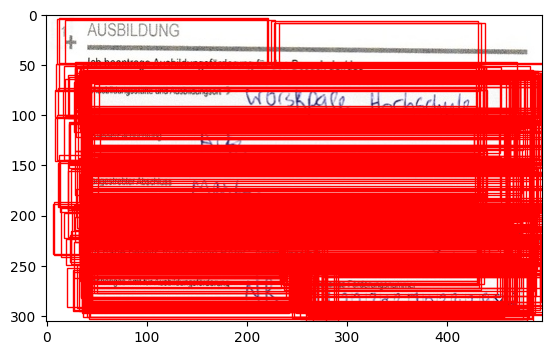

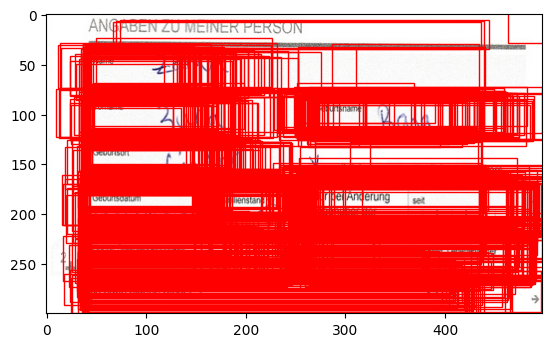

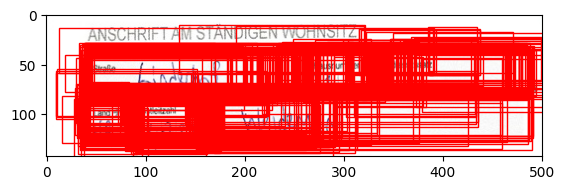

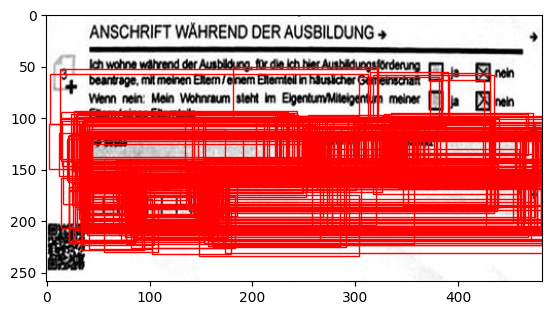

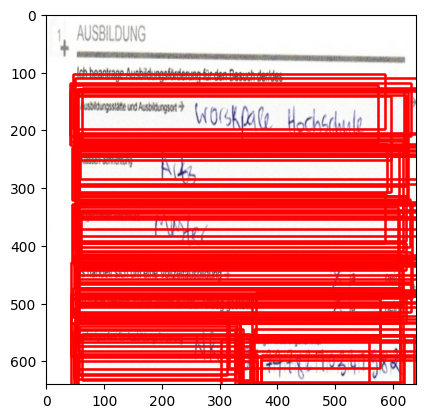

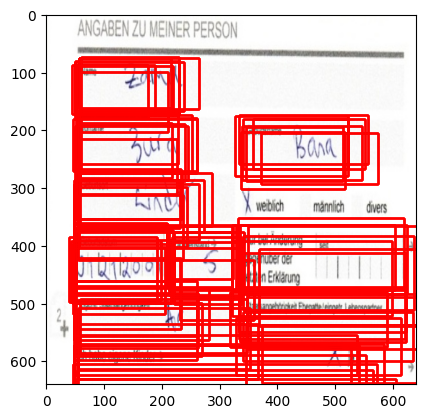

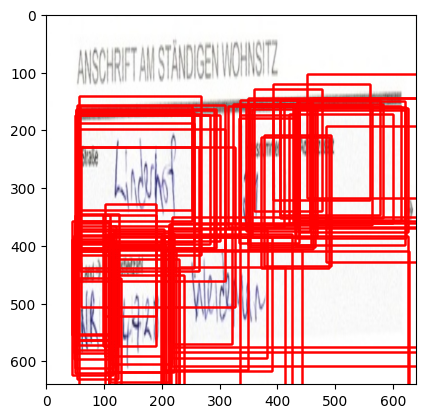

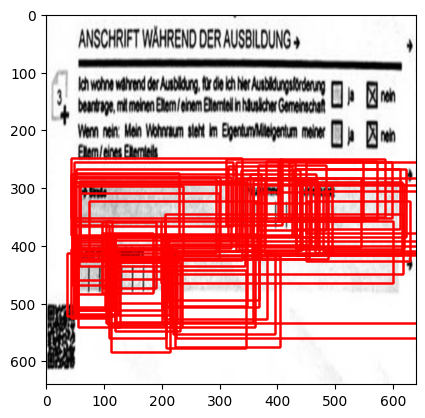

In [56]:
show_image(main_images_paths[0],sub_boxes_main_class_1)
show_image(main_images_paths[82],sub_boxes_main_class_2)
show_image(main_images_paths[170],sub_boxes_main_class_3)
show_image(main_images_paths[255],sub_boxes_main_class_4)

show_image(subsset_scaled_image_paths[0],scaled_sub_boxes_main_class_1)
show_image(subsset_scaled_image_paths[82],scaled_sub_boxes_main_class_2)
show_image(subsset_scaled_image_paths[170],scaled_sub_boxes_main_class_3)
show_image(subsset_scaled_image_paths[255],scaled_sub_boxes_main_class_4)

In [58]:
#create 4 datasets
#image_paths
#shape(81,x)
subset_images_paths_1 = []
subset_images_paths_2 = []
subset_images_paths_3 = []
subset_images_paths_4 = []
for i in range(len(subsset_scaled_image_paths)):
        if i < len(image_names): #Ausbildung
            subset_images_paths_1.append(subsset_scaled_image_paths[i])
        elif (i >= len(image_names)) and (i < (len(image_names)*2)) :#Person
            subset_images_paths_2.append(subsset_scaled_image_paths[i])
        elif (i >= (len(image_names)*2)) and (i < (len(image_names)*3)) :#Wohnsitz
            subset_images_paths_3.append(subsset_scaled_image_paths[i])
        elif (i >= (len(image_names)*3)) and (i < (len(image_names)*4)) :#Wohnsitz_während_Ausildung
            subset_images_paths_4.append(subsset_scaled_image_paths[i])
#classes
subset_class_ids_1_1 = []
subset_class_ids_2_2 = []
subset_class_ids_3_3 = []
subset_class_ids_4_4 = []
subset_class_ids_1 = []
subset_class_ids_2 = []
subset_class_ids_3 = []
subset_class_ids_4 = []
classes=[]
#shape(81,x)
for i in range(len(subset_class_ids_all[0])):
        if i < num_ausbildungs_ids: #Ausbildung
                subset_class_ids_1_1.append(subset_class_ids_all[0][i])
        elif (i >= num_ausbildungs_ids) and (i < num_ausbildungs_ids + num_personen_ids) :#Person
                subset_class_ids_2_2.append(subset_class_ids_all[0][i])
        elif (i >= num_ausbildungs_ids + num_personen_ids) and (i < num_ausbildungs_ids + num_personen_ids + num_wohnsitz_ids) :#Wohnsitz
                subset_class_ids_3_3.append(subset_class_ids_all[0][i])
        elif (i >= num_ausbildungs_ids + num_personen_ids + num_wohnsitz_ids) and (i < num_ausbildungs_ids + num_personen_ids + num_wohnsitz_ids + num_wohnsitz_waehrend_ausbildung_ids) :#Wohnsitz_während_Ausildung
                subset_class_ids_4_4.append(subset_class_ids_all[0][i])

for i in range (0,len(image_names)):
    subset_class_ids_1.append(subset_class_ids_1_1)
    subset_class_ids_2.append(subset_class_ids_2_2)
    subset_class_ids_3.append(subset_class_ids_3_3)
    subset_class_ids_4.append(subset_class_ids_4_4)

#boxen
subset_boxes_1 = []
subset_boxes_2 = []
subset_boxes_3 = []
subset_boxes_4 = []
#shape(18,x,4)
def shape_to_3_tupel(num_images, num_classes, scaled_boxes):
    subset_boxes = []
    arr= np.array(scaled_boxes)
    arr_1=arr.reshape(num_images,num_classes,4)
    for j in range(0,num_images):
        arr_1_1=[]
        for i in range(0,num_classes):
            arr_1_1.append(arr_1[i][0])
        subset_boxes.append(arr_1_1)
    return subset_boxes


subset_boxes_1 = shape_to_3_tupel(len(image_names), num_ausbildungs_ids, scaled_sub_boxes_main_class_1)
subset_boxes_2 = shape_to_3_tupel(len(image_names), num_personen_ids, scaled_sub_boxes_main_class_2)
subset_boxes_3 = shape_to_3_tupel(len(image_names), num_wohnsitz_ids, scaled_sub_boxes_main_class_3)
subset_boxes_4 = shape_to_3_tupel(len(image_names), num_wohnsitz_waehrend_ausbildung_ids, scaled_sub_boxes_main_class_4)


In [59]:
main_class_ids = []
for i in range(len(subset_image_paths_all)):
    main_class_ids.append([0,1,2,3])



In [ ]:
#Entfernen fehlerhafter Annotationen aus Datensatz
#main
indexes_of_false_annotations_main = [31,31,31]
main_image_names = []


for img in subset_image_paths_all:
    main_image_names.append(img)

for index in indexes_of_false_annotations_main:
    main_bbox.pop(index)
    main_image_names.pop(index)
    main_class_ids.pop(index)

#sub 
indexes_of_false_annotations_sub = [31,31,31]


def pop_annotaions(classes, images, boxes, indexes):
    for index in indexes:
        boxes.pop(index)
        images.pop(index)
        classes.pop(index)

pop_annotaions(subset_class_ids_1, subset_images_paths_1, subset_boxes_1, indexes_of_false_annotations_sub)
pop_annotaions(subset_class_ids_2, subset_images_paths_2, subset_boxes_2, indexes_of_false_annotations_sub)
pop_annotaions(subset_class_ids_3, subset_images_paths_3, subset_boxes_3, indexes_of_false_annotations_sub)
pop_annotaions(subset_class_ids_4, subset_images_paths_4, subset_boxes_4, indexes_of_false_annotations_sub)

#pop_annotaions(subset_class_ids_4, subset_images_paths_4, subset_boxes_4, indexes_of_false_annotations_sub)


In [ ]:
classes=[]
images=[]
box=[]
#shape (324,) subset aus 4 main_boxen
for i in range(len(subset_boxes_1)):
    box.append(subset_boxes_1[i])
    images.append(subset_images_paths_1[i])
    classes.append(subset_class_ids_1[i])
for i in range(len(subset_boxes_2)):
    box.append(subset_boxes_2[i])
    images.append(subset_images_paths_2[i])
    classes.append(subset_class_ids_2[i])
for i in range(len(subset_boxes_3)):
    box.append(subset_boxes_3[i])
    images.append(subset_images_paths_3[i])
    classes.append(subset_class_ids_3[i])
for i in range(len(subset_boxes_4)):
    box.append(subset_boxes_4[i])
    images.append(subset_images_paths_4[i])
    classes.append(subset_class_ids_4[i])

#hinzugügen des sets der ganzen Seite
"""for i in range(len(subset_boxes_all)):
    box.append(subset_boxes_all[i])
    images.append(subset_image_paths_all[i])
    classes.append(subset_class_ids_all[i])"""


In [28]:
def create_data_tensor(image_paths,classes,bbox):
    bbox = tf.ragged.constant(bbox, dtype=tf.float32)
    #classes = tf.ragged.constant(classes, dtype=tf.int64)
    image_paths = tf.ragged.constant(image_paths, dtype=tf.string)
    data = tf.data.Dataset.from_tensor_slices((image_paths, classes, bbox))
    return data

In [ ]:
import numpy as np
import tensorflow as tf

def one_hot_encode_2d_to_3d(input_array):
    # Find the maximum length of subarrays
    max_length = max(len(row) for row in input_array)

    # Pad subarrays with -1 to make them of equal length
    padded_arrays = [row + [-1] * (max_length - len(row)) for row in input_array]

    # Find the unique values and their indices
    unique_values = np.unique(np.concatenate(padded_arrays))
    print(unique_values)
    # Number of classes is the total number of unique values
    num_classes = len(unique_values)
    print(padded_arrays)
    # One-hot encode using TensorFlow
    one_hot_encoded = [tf.one_hot(np.searchsorted(unique_values, row), depth=num_classes) for row in padded_arrays]

    # Stack the one-hot encoded arrays to form a 3D array
    reshaped_encoded = tf.stack(one_hot_encoded)

    return reshaped_encoded.numpy()

# Set print options to display the entire array without truncation
np.set_printoptions(threshold=np.inf, linewidth=np.inf)

# Perform one-hot encoding
subset_class_ids_all_3d = one_hot_encode_2d_to_3d(classes)

#print(subset_class_ids_all_3d)


In [19]:
new_sub_data_all = create_data_tensor(images,subset_class_ids_all_3d, box )


In [20]:
def create_train_test_data(split, data_tensor):
    num_val = int(split * SPLIT_RATIO)#int(len(image_path_list)
    val_data = data_tensor.take(num_val)
    train_data = data_tensor.skip(num_val)
    return val_data, train_data

In [21]:
new_sub_data_all = new_sub_data_all.shuffle(len(images), reshuffle_each_iteration=True)


In [22]:
sub_val_data_all, sub_train_data_all  = create_train_test_data(len(images) , new_sub_data_all)


In [23]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image
 

def load_dataset(image_path, classes, bbox):
    # Read Image
    image = load_image(image_path)
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}

In [24]:
def augment_brightness_and_contrast(data_dict):
    # Apply brightness and contrast augmentation
    data_dict["images"] = tf.image.random_brightness(data_dict["images"], max_delta=0.5)
    data_dict["images"] = tf.image.random_contrast(data_dict["images"], lower=0.7, upper=1)
    
    return data_dict

In [25]:
def create_train_ds(train_data):
    train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
    train_ds = train_ds.map(augment_brightness_and_contrast, num_parallel_calls=tf.data.AUTOTUNE)
    train_ds = train_ds.shuffle(BATCH_SIZE * 8)
    train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
    #train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)
    return train_ds

In [26]:
resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640),
    #target_size=(1344, 768),
    scale_factor=(1, 1),
    bounding_box_format="xyxy",
)

def create_val_ds(val_data):
    val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_ds.shuffle(BATCH_SIZE * 8)
    val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
    val_ds = val_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)
    return val_ds

In [30]:
sub_val_ds_all= create_train_ds(sub_val_data_all)
sub_train_ds_all = create_train_ds(sub_train_data_all)


In [28]:
def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]

def create_train_val_tuple(train_ds,val_ds):
    train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
    train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
    val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_ds.prefetch(tf.data.AUTOTUNE)
    return train_ds, val_ds


In [31]:
sub_train_ds_all,sub_val_ds_all=create_train_val_tuple(sub_train_ds_all,sub_val_ds_all)


In [981]:
def define_backbone():
    backbone =  keras_cv.models.ResNet50Backbone.from_preset(
            "resnet50_imagenet",

    )
    return backbone

In [1019]:
def define_backbone():
    backbone =  keras_cv.models.MobileNetV3Backbone.from_preset(
                "mobilenet_v3_large_imagenet",

    )
    return backbone

#### rest_net50

In [988]:
num_classes = len(sub_class_mapping) +1 # 29
aspect_ratios = [0.5, 1.0, 2.0]
scales = [0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05]
backbone = define_backbone()
max_length_batch = 10

In [989]:
print(num_classes)

30


#### mobilenet 

In [1020]:
num_classes = len(sub_class_mapping) +1 # 29
aspect_ratios = [1.0, 2.0, 3.0, 4.0, 5.0]  
scales = [0.1, 0.2, 0.3, 0.5, 0.7, 1.0, 1.5, 2.0]  
backbone = define_backbone()
max_length_batch = 10

In [1021]:
def preprocess_dataset(images, bounding_boxes):
    # Convert 'images' to a dense tensor
    images = images

    bounding_boxes['classes'] = bounding_boxes['classes']
    bounding_boxes['boxes'] = bounding_boxes['boxes']

    # Create a dictionary with input and target values
    inputs = {'input_layer': images}
    targets = {'boxes': bounding_boxes['boxes'], 'classes': bounding_boxes['classes']}

    return inputs, targets

def prepare_data_for_model(images, bounding_boxes):
    inputs, targets = preprocess_dataset(images, bounding_boxes)

    # Convert Ragged Tensor to dense tensor
    inputs['input_layer'] = tf.RaggedTensor.to_tensor(inputs['input_layer'])
    targets['boxes'] = tf.RaggedTensor.to_tensor(targets['boxes'])
    #targets['classes'] = tf.RaggedTensor.to_tensor(targets['classes'])
    
        # One-hot encode the class labels
    #targets['classes'] = tf.one_hot(tf.cast(tf.squeeze(targets['classes'], axis=-1), dtype=tf.int32), depth=num_classes)

    # Set a fixed value for the maximum number of ground truth boxes and classes
    max_boxes_per_image = 10
   # max_classes_per_image = 10

    # Pad the ground truth boxes and classes up to the fixed maximum numbers
    paddings_boxes = [[0, 0], [0, max_boxes_per_image - tf.shape(targets['boxes'])[1]], [0, 0]]
    targets['boxes'] = tf.pad(targets['boxes'], paddings=paddings_boxes, constant_values=-1)
    
    # Pad the ground truth classes
    #paddings_classes = [[0, 0], [0, max_boxes_per_image - tf.shape(targets['classes'])[1]], [0, 0]]
    #targets['classes'] = tf.pad(targets['classes'], paddings=paddings_classes, constant_values=-1)
    
    return inputs, targets




# Create the dataset with prepared data
sub_val_ds_kopie = sub_val_ds_all.map(prepare_data_for_model)



In [ ]:
def define_ssd_model(backbone, num_classes, aspect_ratios, scales):
    global boxes_var, classes_var

    num_default_boxes = len(aspect_ratios) * len(scales)
    input_layer = layers.Input(shape=backbone.input_shape[1:], name='input_layer')

    #backbone_output = backbone.output
    backbone_output = backbone(input_layer)

    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(backbone_output)
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)


    class_scores = layers.Conv2D(num_default_boxes * num_classes, (3, 3), padding='same', name='class_scores')(x)
    class_scores = layers.Reshape((-1, num_classes), name='classes_reshape')(class_scores)
    class_scores = layers.Activation('sigmoid', name='classes')(class_scores)

    box_coords = layers.Conv2D(num_default_boxes * 4, (3, 3), padding='same', name='box_coords')(x)
    box_coords = layers.Reshape((-1, 4), name='boxes')(box_coords)
    boxes_var= box_coords
    classes_var =class_scores
    nms_layer = NMSAndReshapeLayer(name='nms_and_reshape')
    selected_boxes_3d, selected_class_scores_3d = nms_layer([box_coords, class_scores])

    SSD_model = keras.Model(inputs=input_layer, outputs={'boxes': selected_boxes_3d, 'classes': selected_class_scores_3d}, name='ssd_model')
    return SSD_model
    
class NMSAndReshapeLayer(layers.Layer):
    def __init__(self, max_output_size=max_length_batch, iou_threshold=0.1, score_threshold=0.1, **kwargs):
        super(NMSAndReshapeLayer, self).__init__(**kwargs)
        self.max_output_size = max_output_size
        self.iou_threshold = iou_threshold
        self.score_threshold = score_threshold

    def call(self, inputs, max_output_size=None):
        """
        Apply NMS and reshape selected boxes and class scores.

        Args:
            inputs: A tuple (box_coords, class_scores).

        Returns:
            Tuple of selected_boxes_3d and selected_class_scores_3d.
        """
        # inputs should be a tuple (box_coords, class_scores)
        box_coords, class_scores = inputs

        # Ensure the shapes are as expected
        assert len(box_coords.shape) == 3 and len(class_scores.shape) == 3, "Input shapes are not as expected."
        
          # Convert box_coords from [x1, y1, x2, y2]   to [y1, x1, y2, x2] format
        box_coords_for_nms = tf.stack([box_coords[:, :, 1], box_coords[:, :, 0],
                                       box_coords[:, :, 3], box_coords[:, :, 2]], axis=-1)

        max_probs = tf.reduce_max(class_scores, axis=-1, keepdims=True)

        # Apply NMS to select top max_output_size boxes
        selected_indices = tf.image.non_max_suppression(
            tf.reshape(box_coords_for_nms, (-1, 4)),
            tf.reshape(max_probs, (-1,)),
            max_output_size=(2*self.max_output_size),
            iou_threshold=self.iou_threshold,
            score_threshold=self.score_threshold,
        )
        #print("before anything seleceted indices ", selected_indices)
        if len(selected_indices) > (2*self.max_output_size):
            #print(" selected indices bigger than {2*self.max_output_size} ",len(selected_indices))
            sorted_indices = tf.argsort(max_probs, direction='DESCENDING')
            #print("choosen selected indices now are  ",len(selected_indices))
            #print("choosen selected indices now are  ",selected_indices)

                # Sort indices for correct slicing
        selected_indices = tf.sort(selected_indices) # if selected indices is less than 40 pad both classes and boxes output
        #print("self.max_output_size number ",self.max_output_size)

        selected_indices = selected_indices[:(2*self.max_output_size)]

        if len(selected_indices) == (2*self.max_output_size):
            # Proceed with the code when there are 40 elements
            selected_boxes = tf.gather(tf.reshape(box_coords, (-1, 4)), selected_indices)
            selected_class_scores = tf.gather(tf.reshape(class_scores, (-1, class_scores.shape[-1])), selected_indices)
        else:
            # Pad selected boxes and class scores to the desired shape
            #print("length of indices less than than {2*self.max_output_size}  ", len(selected_indices))
        
            # Pad with -1
            paddings = [[0, 2 * self.max_output_size - len(selected_indices)], [0, 0]]
        
            # Pad selected boxes
            selected_boxes = tf.pad(tf.gather(tf.reshape(box_coords, (-1, 4)), selected_indices), paddings, constant_values=-1)
        
            # Pad selected class scores
            selected_class_scores = tf.pad(tf.gather(tf.reshape(class_scores, (-1, class_scores.shape[-1])), selected_indices), paddings, constant_values=-1)
               
        num_images = tf.shape(box_coords)[0]
        selected_boxes_3d = tf.reshape(selected_boxes, (num_images, self.max_output_size, 4))
        selected_class_scores_3d = tf.reshape(selected_class_scores, (num_images, self.max_output_size, class_scores.shape[-1]))

        return selected_boxes_3d, selected_class_scores_3d


In [1023]:
def define_optimizer():
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=LEARNING_RATE,
        global_clipnorm=GLOBAL_CLIPNORM, #This ensures that gradients, which influence the model’s parameter updates, 
                                        # don’t become exceedingly large and destabilize training.
    )
    return optimizer

In [1024]:
SSD_model = define_ssd_model(backbone, num_classes, aspect_ratios, scales)
SSD_model.summary()

Model: "ssd_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, None, None, 3)]      0         []                            
                                                                                                  
 mobile_net_v3_backbone_7 (  (None, None, None, 960)      2996352   ['input_layer[0][0]']         
 MobileNetV3Backbone)                                                                             
                                                                                                  
 conv2d_237 (Conv2D)         (None, None, None, 256)      2212096   ['mobile_net_v3_backbone_7[0][
                                                                    0]']                          
                                                                                          

In [1025]:
from keras.losses import binary_crossentropy
from keras.losses import Loss

class CustomHuberLoss(tf.keras.losses.Loss):
    def __init__(self, delta=0.1): # delta = 0.1 mobilenet, restnet = 1.0
        super(CustomHuberLoss, self).__init__()
        self.huber_loss = tf.keras.losses.Huber(delta=delta)

    def call(self, y_true, y_pred):
        # Convert ragged tensors to dense tensors
        if isinstance(y_true, tf.RaggedTensor):
            y_true = y_true.to_tensor()
        if isinstance(y_pred, tf.RaggedTensor):
            y_pred = y_pred.to_tensor()

        # Ensure both y_true and y_pred are dense tensors
        y_true = tf.convert_to_tensor(y_true)
        y_pred = tf.convert_to_tensor(y_pred)

        # Create a mask for each sample in the batch based on the actual shape of y_true
        mask = tf.math.logical_not(tf.math.equal(tf.reduce_sum(y_true, axis=-1), 0))
        mask = tf.cast(mask, dtype=tf.float32)

        # Use Huber loss
        loss = self.huber_loss(y_true, y_pred)
        #print("y_true boxes ",y_true)
        #print("y_pred boxes ",y_pred)
        loss *= mask
        return loss




class CustomCategoricalCrossEntropy(tf.keras.losses.Loss):
    def __init__(self, **kwargs):
        super(CustomCategoricalCrossEntropy, self).__init__(**kwargs)
        self.categorical_crossentropy = tf.keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)

    def call(self, y_true, y_pred):
        #tf.print("y_true classes:", y_true.shape)
        #tf.print("y_pred classes:", y_pred.shape)

        # Create a mask for each sample in the batch based on the actual shape of y_true
        mask = tf.math.logical_not(tf.math.equal(tf.reduce_sum(y_true, axis=-1), 0))
        mask = tf.reduce_sum(tf.cast(tf.math.logical_and(tf.math.logical_not(tf.math.equal(y_true, 0)), y_true != -1), dtype=tf.float32), axis=-1)
        #print("mask.....",mask.shape)
        # Calculate categorical cross-entropy loss
        loss = self.categorical_crossentropy(y_true, y_pred)

        # Apply the mask to the loss
        loss *= mask

        # Calculate the mean loss, ignoring padded values
        mean_loss = tf.reduce_sum(loss) / tf.reduce_sum(mask)
        #print("y_true classes ",y_true)
        #print("y_pred classes ",y_pred)
        #print ("mean_loss...",mean_loss)
        return mean_loss


In [1026]:
def compile_model(model):

    model.compile(
        optimizer=define_optimizer(),
        loss={
            'boxes': CustomHuberLoss(delta=0.1),  # delta = 0.1 mobilenet, restnet = 1.0
            'classes': CustomCategoricalCrossEntropy()
        },
        loss_weights={'boxes': 1.0, 'classes': 1.0},
        metrics={
            'boxes': ['accuracy'],
            'classes': ['accuracy']
        }
    )
    model.run_eagerly = True

compile_model(SSD_model)

In [976]:
SSD_model = define_ssd_model(backbone, num_classes, aspect_ratios, scales)

# Load the saved weights
SSD_model.load_weights(MODEL_PATH + "/ssd_model_checkpoint_sub_all.h5")


In [1032]:
SSD_model = define_ssd_model(backbone, num_classes, aspect_ratios, scales)

# Load the saved weights
SSD_model.load_weights(MODEL_PATH + "/ssd_model_checkpoint_sub_all_mobilenet.h5")


In [706]:

def find_max_indices(y_pred_no_padding, first_occurrences):
    # Extract values for the first set
    min_search_index_1 = first_occurrences[0, 0]
    max_search_index_1 = tf.reduce_max(first_occurrences[0])

    # Extract values for the second set
    min_search_index_2 = first_occurrences[1, 0]
    max_search_index_2 = tf.reduce_max(first_occurrences[1])

    cut_array_range1 = [
        [sublist[i] for i in range(min_search_index_1, max_search_index_1 + 1)] for sublist in y_pred_no_padding[0]
    ]

    cut_array_range2 = [
        [sublist[i] for i in range(min_search_index_2, max_search_index_2 + 1)] for sublist in y_pred_no_padding[1]
    ]

    # Find the indices of max values in the cut array for each sublist in the first set (data[0])
    max_indices_range1 = [
        min_search_index_1 + idx for idx, value in enumerate(cut_array_range1[0]) if value == max(cut_array_range1[0])
    ]

    max_indices_range2 = [
        min_search_index_2 + idx for idx, value in enumerate(cut_array_range2[0]) if value == max(cut_array_range2[0])
    ]

    # Create an array of maximum values for each sublist in cut_array_range1
    max_values1 = [max(sublist) for sublist in cut_array_range1]
    max_values2 = [max(sublist) for sublist in cut_array_range2]

    # Find the indices of the maximum values in the specified range for the first set
    max_indices_range1 = [
        np.argmax(sublist[min_search_index_1:max_search_index_1]) + min_search_index_1 for sublist in y_pred_no_padding[0]
    ]

    # Find the indices of the maximum values in the specified range for the second set
    max_indices_range2 = [
        np.argmax(sublist[min_search_index_2:max_search_index_2]) + min_search_index_2 for sublist in y_pred_no_padding[1]
    ]

    total_max_indices_combined = [max_indices_range1, max_indices_range2]

    return total_max_indices_combined



#### prediction with restnet_50 backbone

In [966]:
y_pred_classes_trial = None
first_occurrences = None
def visualize_detections(model, dataset, class_mapping):
    global  y_pred_classes_trial
    
    images, y_true = next(iter(dataset.take(1)))

    y_pred = model.predict(images)
    
    # Extract NumPy arrays from the dictionary
    boxes_np = y_pred['boxes']
    classes_np = y_pred['classes']
    # Create a new tensor excluding the first value for each array in 'y_true'
    y_true_no_padding = y_true['classes'][:, :, 1:]
    y_pred_no_padding = y_pred['classes'][:, :, 1:]
   
    first_occurrences = tf.argmax(y_true_no_padding, axis=-1)
       
    # Extract values for the first set
    min_search_index_1 = first_occurrences[0, 0]
    max_search_index_1 = tf.reduce_max(first_occurrences[0])
    
    # Extract values for the second set
    min_search_index_2 = first_occurrences[1, 0]
    max_search_index_2 = tf.reduce_max(first_occurrences[1])   


    cut_array_range1 = [
        [sublist[i] for i in range(min_search_index_1, max_search_index_1 + 1)] for sublist in y_pred_no_padding[0]
    ]
    
    cut_array_range2  = [
        [sublist[i] for i in range(min_search_index_2, max_search_index_2 + 1)] for sublist in y_pred_no_padding[1]
    ]
    
    # Find the indices of max values in the cut array for each sublist in the first set (data[0])
    max_indices_range1 = [
        min_search_index_1 + idx for idx, value in enumerate(cut_array_range1[0]) if value == max(cut_array_range1[0])
    ]
    
    max_indices_range2 = [
        min_search_index_2 + idx for idx, value in enumerate(cut_array_range2[0]) if value == max(cut_array_range2[0])
    ]

     
    # Find the indices of the maximum values in the specified range for the first set
    max_indices_range1 = [
        np.argmax(sublist[min_search_index_1:max_search_index_1 ]) + min_search_index_1 for sublist in y_pred_no_padding[0]
    ]
    
    # Find the indices of the maximum values in the specified range for the second set
    max_indices_range2 = [
        np.argmax(sublist[min_search_index_2:max_search_index_2 ]) + min_search_index_2 for sublist in y_pred_no_padding[1]
    ]
    total_max_indices_combined = [max_indices_range1, max_indices_range2]  
        
    for i in range(boxes_np.shape[0]):
     for j in range(boxes_np.shape[1]):
        if boxes_np[i, j, 0] == -1:
            boxes_np[i, j, :] = -1
            total_max_indices_combined[i][j] = -1

    visualization.plot_bounding_box_gallery(
        images['input_layer'].numpy(),
        value_range=(0, 255),
        bounding_box_format='xyxy',
        y_pred={'classes': total_max_indices_combined, 'boxes': boxes_np},
        scale=5,
        rows=1,
        cols=1,
        show=True,
        font_scale=0.4,
        class_mapping=class_mapping,
    )


1/1 [==============================] - 2s 2s/step


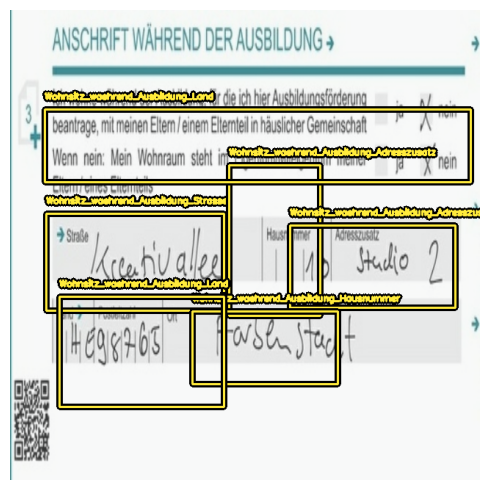

In [974]:
visualize_detections(SSD_model, dataset=sub_val_ds_kopie, class_mapping= sub_class_mapping)

In [828]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
def visualize_bounding_boxes(image, classes, boxes, class_mapping=None):
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    for class_id, box_set in zip(classes, boxes):
        if class_mapping:
            # Convert class_id to a single-item iterable (list)
            class_id = [class_id]
            # Convert class_id to a tuple
            class_id = tuple(class_id)
            class_name = class_mapping.get(class_id, f"Class {class_id}")
        else:
            class_name = f"Class {class_id}"

        # Check if the box_set is valid (not empty) and iterable
        if box_set and isinstance(box_set[0], (list, np.ndarray)):
            for box in box_set:
                x_min, y_min, x_max, y_max = box
                width = x_max - x_min
                height = y_max - y_min
                rect = patches.Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
                ax.text(x_min, y_min, class_name, color='r', fontsize=8, bbox=dict(facecolor='white', alpha=0.7))
        else:
            # Handle single set of values (floats)
            x_min, y_min, x_max, y_max = box_set
            width = x_max - x_min
            height = y_max - y_min
            rect = patches.Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(x_min, y_min, class_name, color='r', fontsize=8, bbox=dict(facecolor='white', alpha=0.7))

    plt.show()

def predict_on_imagepath_plot(image_path, model):
    image = cv2.imread(image_path)
    resized_image = cv2.resize(image, (640, 640))
    batch_images = np.concatenate([resized_image[np.newaxis, ...], resized_image[np.newaxis, ...]], axis=0)

    y_pred = model.predict(batch_images)

    # Extract NumPy arrays from the dictionary
    boxes_np = y_pred['boxes']
    classes_np = y_pred['classes']
    classes_np = classes_np[:, :, 1:]

    valid_indices = np.all(boxes_np != -1, axis=-1)
    boxes_np = boxes_np[valid_indices]
    classes_np = classes_np[valid_indices]
    # Convert one-hot encoded classes to integer labels
    classes_int = np.argmax(classes_np, axis=-1)

    # Proceed with the custom visualization
    visualize_bounding_boxes(
        resized_image,
        classes_int,  # Pass one-hot encoded classes
        boxes_np.tolist(),  # Convert NumPy array to list
        class_mapping=class_mapping
    )



1/1 [==============================] - 2s 2s/step


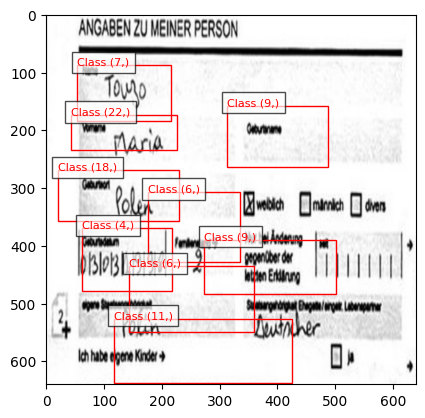

In [975]:
image_path1 = (IMAGE_PATH+ '/640x640_main_classes_scaled/1_29.jpg') 
predict_on_imagepath_plot(image_path1, SSD_model)


### prediction with mobilenet backbone

In [1033]:
def visualize_detections(model, dataset, class_mapping):
    global  y_pred_classes_trial
    
    images, y_true = next(iter(dataset.take(1)))

    y_pred = model.predict(images)
    
    # Extract NumPy arrays from the dictionary
    boxes_np = y_pred['boxes']
    classes_np = y_pred['classes']
    # Create a new tensor excluding the first value for each array in 'y_true'
    y_true_no_padding = y_true['classes'][:, :, 1:]
    y_pred_no_padding = y_pred['classes'][:, :, 1:]
   
    first_occurrences = tf.argmax(y_true_no_padding, axis=-1)
       
    # Extract values for the first set
    min_search_index_1 = first_occurrences[0, 0]
    max_search_index_1 = tf.reduce_max(first_occurrences[0])
    
    # Extract values for the second set
    min_search_index_2 = first_occurrences[1, 0]
    max_search_index_2 = tf.reduce_max(first_occurrences[1])   


    cut_array_range1 = [
        [sublist[i] for i in range(min_search_index_1, max_search_index_1 + 1)] for sublist in y_pred_no_padding[0]
    ]
    
    cut_array_range2  = [
        [sublist[i] for i in range(min_search_index_2, max_search_index_2 + 1)] for sublist in y_pred_no_padding[1]
    ]
    
    # Find the indices of max values in the cut array for each sublist in the first set (data[0])
    max_indices_range1 = [
        min_search_index_1 + idx for idx, value in enumerate(cut_array_range1[0]) if value == max(cut_array_range1[0])
    ]
    
    max_indices_range2 = [
        min_search_index_2 + idx for idx, value in enumerate(cut_array_range2[0]) if value == max(cut_array_range2[0])
    ]

     
    # Find the indices of the maximum values in the specified range for the first set
    max_indices_range1 = [
        np.argmax(sublist[min_search_index_1:max_search_index_1 ]) + min_search_index_1 for sublist in y_pred_no_padding[0]
    ]
    
    # Find the indices of the maximum values in the specified range for the second set
    max_indices_range2 = [
        np.argmax(sublist[min_search_index_2:max_search_index_2 ]) + min_search_index_2 for sublist in y_pred_no_padding[1]
    ]
    total_max_indices_combined = [max_indices_range1, max_indices_range2]  
        
    for i in range(boxes_np.shape[0]):
     for j in range(boxes_np.shape[1]):
        if boxes_np[i, j, 0] == -1:
            boxes_np[i, j, :] = -1
            total_max_indices_combined[i][j] = -1

    visualization.plot_bounding_box_gallery(
        images['input_layer'].numpy(),
        value_range=(0, 255),
        bounding_box_format='xyxy',
        y_pred={'classes': total_max_indices_combined, 'boxes': boxes_np},
        scale=5,
        rows=1,
        cols=1,
        show=True,
        font_scale=0.4,
        class_mapping=class_mapping,
    )


1/1 [==============================] - 5s 5s/step


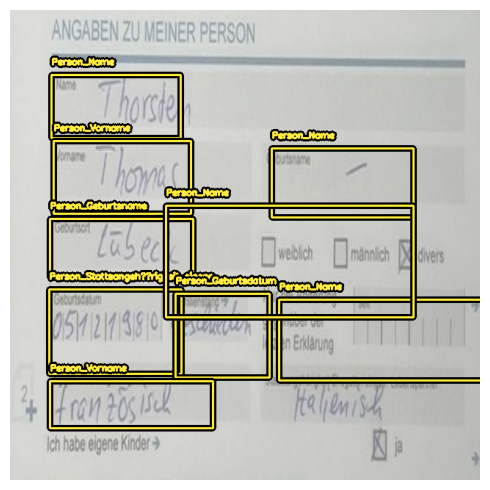

In [1034]:
visualize_detections(SSD_model, dataset=sub_val_ds_kopie, class_mapping= sub_class_mapping)

In [1035]:
def visualize_bounding_boxes(image, classes, boxes, class_mapping=None):
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    for class_id, box_set in zip(classes, boxes):
        if class_mapping:
            # Convert class_id to a single-item iterable (list)
            class_id = [class_id]
            # Convert class_id to a tuple
            class_id = tuple(class_id)
            class_name = class_mapping.get(class_id, f"Class {class_id}")
        else:
            class_name = f"Class {class_id}"

        # Check if the box_set is valid (not empty) and iterable
        if box_set and isinstance(box_set[0], (list, np.ndarray)):
            for box in box_set:
                x_min, y_min, x_max, y_max = box
                width = x_max - x_min
                height = y_max - y_min
                rect = patches.Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
                ax.text(x_min, y_min, class_name, color='r', fontsize=8, bbox=dict(facecolor='white', alpha=0.7))
        else:
            # Handle single set of values (floats)
            x_min, y_min, x_max, y_max = box_set
            width = x_max - x_min
            height = y_max - y_min
            rect = patches.Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(x_min, y_min, class_name, color='r', fontsize=8, bbox=dict(facecolor='white', alpha=0.7))

    plt.show()

def predict_on_imagepath_plot(image_path, model):
    image = cv2.imread(image_path)
    resized_image = cv2.resize(image, (640, 640))
    batch_images = np.concatenate([resized_image[np.newaxis, ...], resized_image[np.newaxis, ...]], axis=0)

    y_pred = model.predict(batch_images)

    # Extract NumPy arrays from the dictionary
    boxes_np = y_pred['boxes']
    classes_np = y_pred['classes']
    classes_np = classes_np[:, :, 1:]

    valid_indices = np.all(boxes_np != -1, axis=-1)
    boxes_np = boxes_np[valid_indices]
    classes_np = classes_np[valid_indices]
    # Convert one-hot encoded classes to integer labels
    classes_int = np.argmax(classes_np, axis=-1)

    # Proceed with the custom visualization
    visualize_bounding_boxes(
        resized_image,
        classes_int,  # Pass one-hot encoded classes
        boxes_np.tolist(),  # Convert NumPy array to list
        class_mapping=class_mapping
    )



1/1 [==============================] - 5s 5s/step


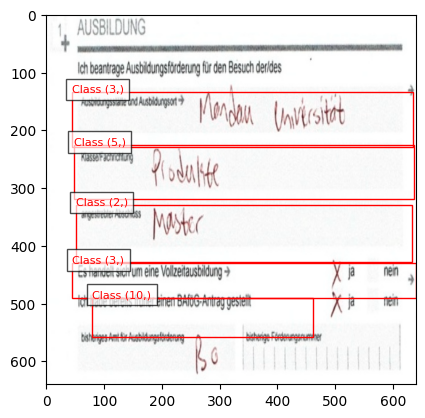

1/1 [==============================] - 1s 814ms/step


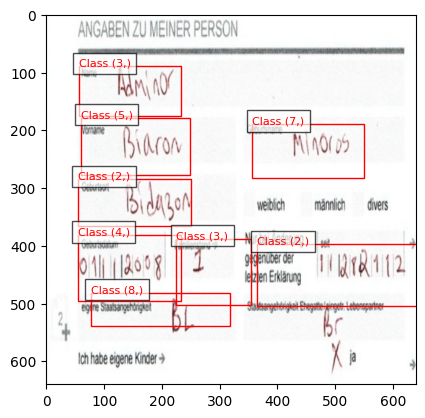

1/1 [==============================] - 1s 754ms/step


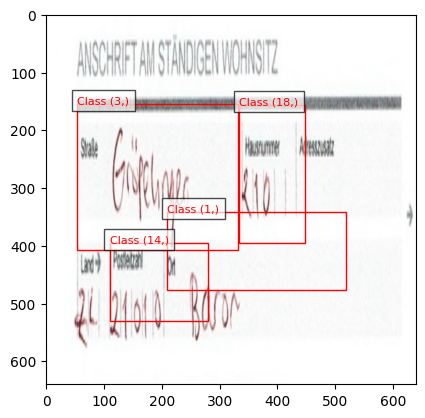

1/1 [==============================] - 1s 799ms/step


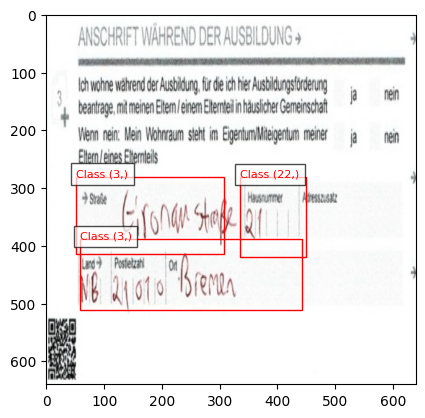

In [1036]:
image_path1 = (IMAGE_PATH+ '/640x640_main_classes_scaled/0_9.jpg') 
predict_on_imagepath_plot(image_path1, SSD_model)

image_path1 = (IMAGE_PATH+ '/640x640_main_classes_scaled/1_9.jpg') 
predict_on_imagepath_plot(image_path1, SSD_model)

image_path1 = (IMAGE_PATH+ '/640x640_main_classes_scaled/2_9.jpg') 
predict_on_imagepath_plot(image_path1, SSD_model)

image_path1 = (IMAGE_PATH+ '/640x640_main_classes_scaled/3_9.jpg') 
predict_on_imagepath_plot(image_path1, SSD_model)


1/1 [==============================] - 0s 388ms/step


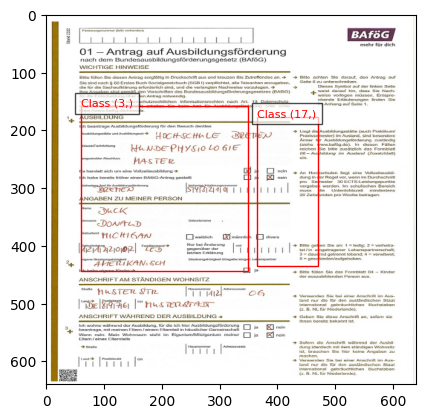

In [1010]:
image_path1 = (IMAGE_PATH+ '/original/image_0002.jpg') 
predict_on_imagepath_plot(image_path1, SSD_model) 

### end sub box training

In [102]:
def visualize_detections(model, dataset, class_mapping):
    global  y_pred_classes_trial
    
    images, y_true = next(iter(dataset.take(1)))

    y_pred = model.predict(images)
    
    # Extract NumPy arrays from the dictionary
    boxes_np = y_pred['boxes']
    classes_np = y_pred['classes']
    # Create a new tensor excluding the first value for each array in 'y_true'
    y_true_no_padding = y_true['classes'][:, :, 1:]
    y_pred_no_padding = y_pred['classes'][:, :, 1:]
   
    first_occurrences = tf.argmax(y_true_no_padding, axis=-1)
       
    # Extract values for the first set
    min_search_index_1 = first_occurrences[0, 0]
    max_search_index_1 = tf.reduce_max(first_occurrences[0])
    
    # Extract values for the second set
    min_search_index_2 = first_occurrences[1, 0]
    max_search_index_2 = tf.reduce_max(first_occurrences[1])   


    cut_array_range1 = [
        [sublist[i] for i in range(min_search_index_1, max_search_index_1 + 1)] for sublist in y_pred_no_padding[0]
    ]
    
    cut_array_range2  = [
        [sublist[i] for i in range(min_search_index_2, max_search_index_2 + 1)] for sublist in y_pred_no_padding[1]
    ]
    
    # Find the indices of max values in the cut array for each sublist in the first set (data[0])
    max_indices_range1 = [
        min_search_index_1 + idx for idx, value in enumerate(cut_array_range1[0]) if value == max(cut_array_range1[0])
    ]
    
    max_indices_range2 = [
        min_search_index_2 + idx for idx, value in enumerate(cut_array_range2[0]) if value == max(cut_array_range2[0])
    ]

     
    # Find the indices of the maximum values in the specified range for the first set
    max_indices_range1 = [
        np.argmax(sublist[min_search_index_1:max_search_index_1 ]) + min_search_index_1 for sublist in y_pred_no_padding[0]
    ]
    
    # Find the indices of the maximum values in the specified range for the second set
    max_indices_range2 = [
        np.argmax(sublist[min_search_index_2:max_search_index_2 ]) + min_search_index_2 for sublist in y_pred_no_padding[1]
    ]
    total_max_indices_combined = [max_indices_range1, max_indices_range2]  
        
    for i in range(boxes_np.shape[0]):
     for j in range(boxes_np.shape[1]):
        if boxes_np[i, j, 0] == -1:
            boxes_np[i, j, :] = -1
            total_max_indices_combined[i][j] = -1

    visualization.plot_bounding_box_gallery(
        images['input_layer'].numpy(),
        value_range=(0, 255),
        bounding_box_format='xyxy',
        y_pred={'classes': total_max_indices_combined, 'boxes': boxes_np},
        scale=5,
        rows=1,
        cols=1,
        show=True,
        font_scale=0.4,
        class_mapping=class_mapping,
    )


1/1 [==============================] - 1s 770ms/step


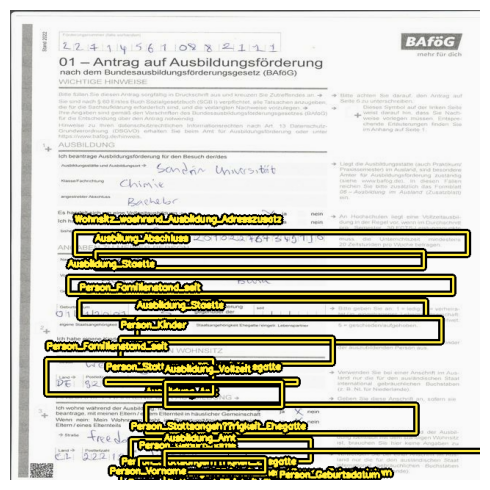

In [103]:
visualize_detections(SSD_model, dataset=sub_val_ds_kopie, class_mapping= sub_class_mapping)